# Cell segmentation

Segmentation of cells in fluorescent microscopy is a relatively common image
characterisation task with variations that are dependent on the specifics of fluorescent
markers for a given experiment. A typical procedure might include

1. Histogram-based threshold estimation to produce a binary image.
1. Cell splitting (separating touching cells) using distance transforms and watershed transform.
1. Refinement of initial segmentation using information from other channels
1. Cell counting/characterisation.

This example demonstrates the procedure on a 3 channel fluorescent microscopy image. The blue channel
is a DNA marker (DAPI) that stains all cells, the red channel is a marker of cell death (Ph3)
while the green channel is a marker of cell proliferation (Ki67). A typical experiment might count the
number of cells and measure size in the different states, where states are determined by presence
of Ph3 and Ki67, various times after treatment with a drug candidate.

## Acknowledgements

The image used in this example come from [Fiji training notes](http://imagej.net/User_Guides) and were contributed by Steve Williams, Peter MacCallum Cancer Centre.


## Cell segmentation and splitting

Histogram-based threshold estimation is performed by the <tt>segChannel</tt> function, listed below.
It applies light smoothing followed by the Li
threshold estimator, one of a range of threshold estimation options available
in SimpleITK. A cell splitting procedure using
distance transforms and a marker-based watershed (implemented by <tt>segBlobs</tt>, also listed below) was then applied to
the resulting mask. Distance transforms replace each foreground pixel with the distance to the
closest background pixel, producing a cone-shaped brightness profile for each circular object. Touching
cells can then be separated using the peaks of the cones as markers in a watershed transform.
A marker image is created by identifying peaks in the distance transform and applying a connected-component labelling.

The inverted distance transform is used as the control image for the watershed transform.


### Load and display

Microscopes use many variants of the tiff format. This one is recognised as 3D by the SimpleITK readers so we extract
slices and recompose as a color image.

In [29]:
library(SimpleITK)
## set up viewing tools
source("viewing.R")

# this is to do with size of display in Jupyter notebooks
if (!exists("default.options")) 
{
default.options <- options()
}

## This will need to change, depending on how stored - Ziv to fix
cntrl <- ReadImage("Control.tif")
## Extract the cha
red <- cntrl[ , , 1]
green <- cntrl[ , , 2]
blue <- cntrl[ , , 3]

cntrl.colour <- Compose(red, green, blue)


Display the image

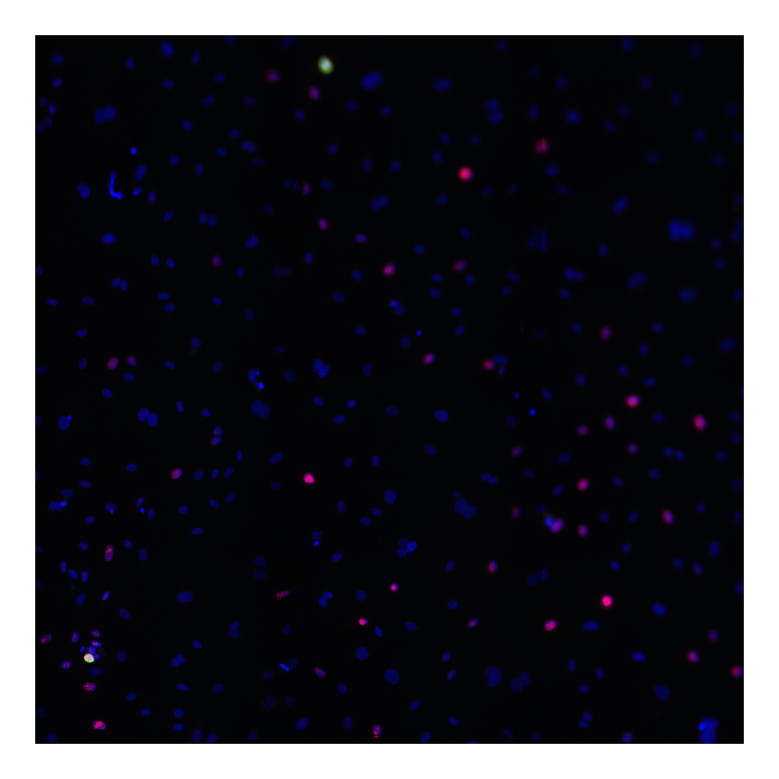

In [14]:
show_inline(cntrl.colour, Dwidth=grid::unit(15, "cm"))

Set up the functions that do segmentation and blob splitting for a channel (i.e. separately for red,green blue)

In [15]:
segChannel <- function(dapi, dtsmooth=3, osmooth=0.5)
{
  # Smoothing
  dapi.smooth <- SmoothingRecursiveGaussian(dapi, osmooth)
  # a thresholding filter - note the class/method interface
  th <- LiThresholdImageFilter()
  th$SetOutsideValue(1)
  th$SetInsideValue(0)
  B <- th$Execute(dapi.smooth)
  # call blob splitting with the thresholded image
  g <- splitBlobs(B, dtsmooth)
  return(list(thresh=B, labels=g$labels, peaks=g$peaks, dist=g$dist))
}
splitBlobs <- function(mask, smooth=1)
{
  # Distance transform - replaces each voxel
  # in a binary image with the distance to the nearest
  # voxel of the other class. Circular objects
  # end up with a conical brightness profile, with
  # the brightest point in the center.
  DT <- DanielssonDistanceMapImageFilter()
  DT$UseImageSpacingOn()
  distim <- DT$Execute(!mask)
  # Smooth the distance transform to avoid peaks being
  # broken into pieces
  distimS <- SmoothingRecursiveGaussian(distim, smooth, TRUE)
  distim <- distimS * Cast(distim > 0, 'sitkFloat32')
  # Find the peaks of the distance transform
  peakF <- RegionalMaximaImageFilter()
  peakF$SetForegroundValue(1)
  peakF$FullyConnectedOn()
  peaks <- peakF$Execute(distim)
  # Label the peaks to use as markers in the watershed transform
  markers <- ConnectedComponent(peaks, TRUE)
  # Apply the watershed transform from markers to the inverted distance
  # transform
  WS <- MorphologicalWatershedFromMarkers(-1 * distim, markers, TRUE, TRUE)
  # Mask the result of watershed (which labels every pixel) with the nonzero
  # parts of the distance transform.
  WS <- WS * Cast(distim > 0, WS$GetPixelID())
  return(list(labels=WS, dist=distimS, peaks=peaks))
}


Segment each channel

In [16]:
dapi.cells <- segChannel(blue, 3)
ph3.cells <- segChannel(red, 3)
Ki67.cells <- segChannel(green, 3)


The DAPI channel provides consistent staining, while the other stains may only occupy parts of a nucleus. We therefore combine DAPI information with Ph3 and Ki67 to produce good segmentations of cells with those markers.

In [17]:
# Create a mask of dapi stain - cells are likely to be reliably segmented
dapi.mask <- dapi.cells$labels !=0
# Mask of cells from other channels, which are likely to be less reliable
ph3.markers <- ph3.cells$thresh * dapi.mask
Ki67.markers <- Ki67.cells$thresh * dapi.mask
# Perform a geodesic reconstruction using the unreliable channels as seeds
ph3.recon <- BinaryReconstructionByDilation(ph3.markers, dapi.mask)
Ki67.recon <- BinaryReconstructionByDilation(Ki67.markers, dapi.mask)


Now we view the results

In [26]:
sx <- 1:550
sy <- 1450:2000
r1 <- red[sx, sy]
g1 <- green[sx, sy]
b1 <- blue[sx, sy]
colsub <- Compose(r1, g1, b1)
dapisub <- dapi.cells$thresh[sx, sy] == 0
dapisplit <- dapi.cells$labels[sx, sy] == 0


A subset of the original - note speckled pattern of red stain in some cells


In [30]:
show_inline(colsub, pad=TRUE)

ERROR: Error in f(...): could not find function "f"


Segmentation of DAPI channel without splitting - note touching cells on mid right that get separated by splitting process.

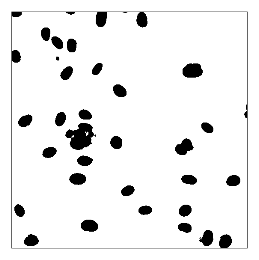

In [20]:
show_inline(dapisub, pad=TRUE)

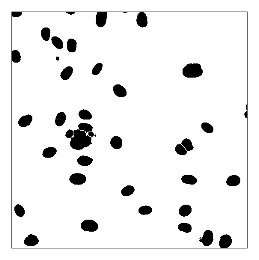

In [21]:
show_inline(dapisplit, pad=TRUE)

Lets check the segmentation of the Ph3 (red) channel. Note that the simple segmentation does not always include complete cells (see lower right)

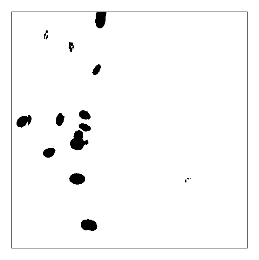

In [22]:

show_inline(ph3.cells$thresh[sx, sy]==0, pad=TRUE)

After geodesic reconstruction the incomplete cells match the DAPI channel segmentation.

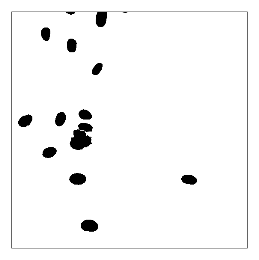

In [23]:
ph3sub <- ph3.recon[sx, sy]==0
show_inline(ph3sub, pad=TRUE)

## Characterization and counting

Image segmentations can lead to quantitative measures such as counts and shape statistics
(e.g., area, perimeter etc). Such measures can be biased by edge effects, so it is useful to
know whether the objects are touching the image edge. The classes used for these steps in
SimpleITK are <tt>ConnectedComponentImageFilter</tt> and <tt>LabelShapeStatisticsImageFilter</tt>.
The former produces a _labelled_ image, in which each binary connected component is given
an different integer voxel value. Label images are used in many segmentation contexts, including
the cell splitting function illustrated earlier. The latter produces shape measures per
connected component. The function below illustrates extraction of centroids, areas and
edge touching measures.

Cell counts are also available from the table dimensions.

In [24]:
# Function to extract the relevant statistics from the labelled images
getCellStats <- function(labelledim)
{
  # create a statistics filter to measure characteristics of
  # each labelled object
  StatsFilt <- LabelShapeStatisticsImageFilter()
  StatsFilt$Execute(labelledim)

  objs <- StatsFilt$GetNumberOfLabels()
  ## create vectors of each measure
  areas <- sapply(1:objs, StatsFilt$GetPhysicalSize)
  boundarycontact <- sapply(1:objs, StatsFilt$GetNumberOfPixelsOnBorder)
  centroid <- t(sapply(1:objs, StatsFilt$GetCentroid))
  # place results in a data frame
  result <- data.frame(Area=areas, TouchingImageBoundary=boundarycontact,
                       Cx=centroid[, 1], Cy=centroid[, 2])
  return(result)
}
## Label the cell masks
ph3.recon.labelled <- ConnectedComponent(ph3.recon)
Ki67.recon.labelled <- ConnectedComponent(Ki67.recon)
## Collect the measures
dapistats <- getCellStats(dapi.cells$labels)
ph3stats <- getCellStats(ph3.recon.labelled)
ki67stats <- getCellStats(Ki67.recon.labelled)
## begin creating a data frame for plotting
dapistats$Stain <- "dapi"
ph3stats$Stain <- "ph3"
ki67stats$Stain <- "ki67"
# Put the data frames together
cellstats <- rbind(dapistats, ph3stats, ki67stats)
cellstats$Stain <- factor(cellstats$Stain)
# Remove cells touching the image boundary
cellstats.no.boundary <- subset(cellstats, TouchingImageBoundary == 0)


Once the data has been collected it can be used for plotting, statistical tests, etc:

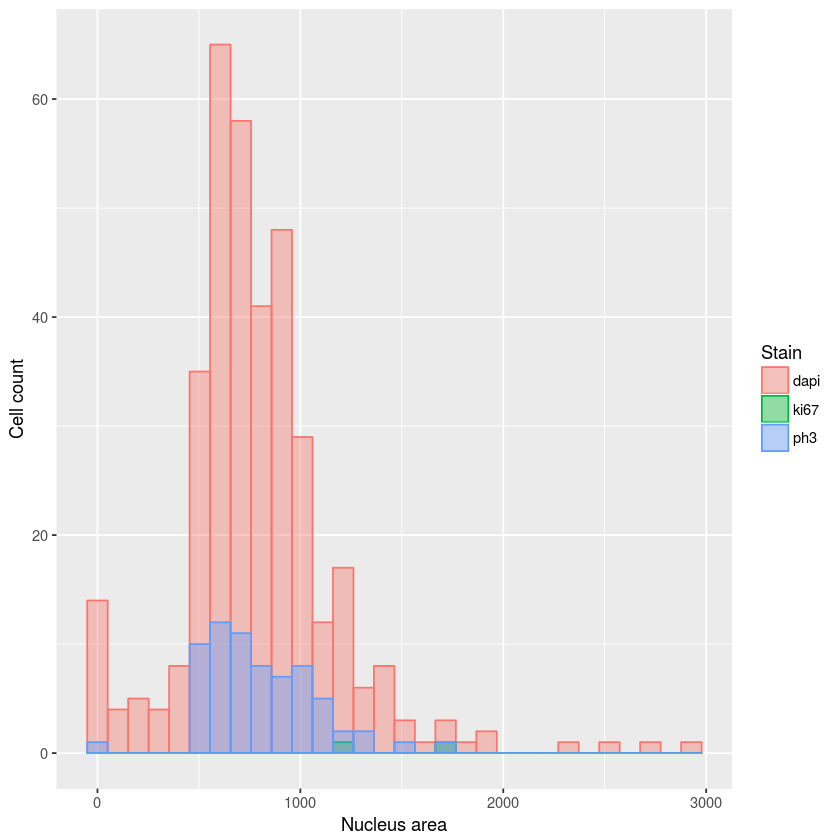

In [31]:
# Reset the plot options after dealing with images
options(default.options)
library(ggplot2)
ggplot(cellstats.no.boundary, aes(x=Area, group=Stain, colour=Stain, fill=Stain)) +
    geom_histogram(position="identity", alpha=0.4, bins=30) + ylab("Cell count") + xlab("Nucleus area")
